## Boyan Hristov, Nedeltscho Petrov

In [6]:
import torch
torch.__version__

'0.3.0.post4'

# Assignment 1

Fill in the code and then print to PDF to send for marking.

## A first look at PyTorch


We will now take a look at a first concrete example of a neural network, which makes use of the Python library PyTorch to learn to classify fashion articles. Unless you already have experience with PyTorch or similar libraries, you will not understand everything about this first example right away. You probably haven't even installed Pytorch yet. Don't worry, that is perfectly fine. We will do all that below.

The problem we are trying to solve here is to classify grayscale images of fashion articles (28 pixels by 28 pixels), into their 10 categories. The dataset we will use is the Fashion-MNIST dataset, a dropin replacement of MNIST which is a classic dataset in the machine learning community, which has been around for almost as long as the field itself and has been very intensively studied. It's a set of 60,000 training images, plus 10,000 test images. You can think of "solving" Fashion-MNIST or MNIST as the "Hello World" of deep learning --- it's what you do to verify that your algorithms are working as expected. As you become a machine learning practitioner, you will see MNIST come up over and over again, in scientific papers, blog posts, and so on.

The Fashion-MNIST and MNIST datasets comes as standard datasets in PyTorch's `torchvision` library, as subclasses of `torch.utils.data.Dataset` which makes it convinent to use as we will see.

Our images are encoded as `PIL.Image.Image` objects, and the labels are simply an array of integers, ranging from 0 to 9.  There is a one-to-one correspondence between the images and the labels.

Before training, we will transform our data by first converting it to a `Tensor` and then  normalizing it so that all image values have mean 0.5 and standard deviation of 1, by composing these operations as `transforms` function to the datasets:

In [7]:
from torchvision import datasets, transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_dataset = datasets.FashionMNIST('data', transform=trans, train=True, download=True)
test_dataset = datasets.FashionMNIST('data', transform=trans, train=False, download=True)

`train_dataset` forms the "training set", the data that the model will learn from. The model will then be tested on the "test set", `test_dataset`. 

Let's have a look at the training data:

In [8]:
len(train_dataset)

60000

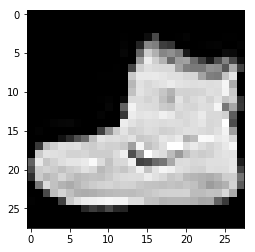

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(train_dataset.train_data[0], cmap='gray')

In [10]:
train_dataset.train_labels[0]

9

Let's have a look at the test data:

In [11]:
len(test_dataset)

10000

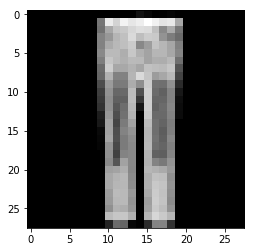

In [12]:
plt.imshow(test_dataset.test_data[15], cmap='gray')

In [13]:
test_dataset.test_labels[15]

1

Our workflow will be as follow: first we will present our neural network with the training data, `train_dataset` via the `DataLoader` iterator. The network will then learn to associate images and labels. Finally, we will ask the network to produce predictions for `test_dataset`, and we will verify if these predictions match the test labels.

Let's build our network --- again, remember that you aren't supposed to understand everything about this example just yet.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=0)

In [15]:
model = Net()
if torch.cuda.is_available():
    model.cuda()

The core building block of neural networks is the "layer", a data-processing module which you can conceive as a "filter" for data. Some data comes in, and comes out in a more useful form. Precisely, layers extract _representations_ out of the data fed into them --- hopefully  representations that are more meaningful for the problem at hand. Most of deep learning really consists of chaining together simple layers  which will implement a form of progressive "data distillation". A deep learning model is like a sieve for data processing, made of a  succession of increasingly refined data filters --- the "layers".

Here our network consists of a sequence of two `Linear` layers, which are densely-connected (also called "fully-connected") neural layers.  The output (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current article image belongs to one of our 10 classes.

To make our network ready for training, we need to pick three more things:

* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be  able to steer itself in the right direction.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

The exact purpose of the loss function and the optimizer will be made clear throughout the next lectures and homeworks. Lets start with the optimizer:

In [16]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [17]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128, 
                                           shuffle=True,
                                           **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=128,
                                          shuffle=False,
                                          **kwargs)

We are now ready to train our network, meaning, we "fit" the model to its training data, which in PyTorch is done via a `train()`  helper which typically contains the loss we wish to minimize and looks like this: 

In [18]:
from torch.autograd import Variable

def train(epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        
        output = model(data)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data[0]))

The quantity being displayed during training in the above helper is: the "loss" of the network over the training data. Let us write a `test()` helper which will print out the accuracy metric of the network over the test data:

In [19]:
def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Now let us  train the network for 5 epochs and print the test set accuracy at the end of each epoch:

In [39]:
%%time
for epoch in range(1, 5 + 1):
    train(epoch)
    test()

Train Epoch: 1 [128/60000 (0%)]	Loss: 4.851589
Train Epoch: 1 [1408/60000 (2%)]	Loss: 4.727163
Train Epoch: 1 [2688/60000 (4%)]	Loss: 4.617854
Train Epoch: 1 [3968/60000 (7%)]	Loss: 4.470588
Train Epoch: 1 [5248/60000 (9%)]	Loss: 4.401217
Train Epoch: 1 [6528/60000 (11%)]	Loss: 4.219746
Train Epoch: 1 [7808/60000 (13%)]	Loss: 4.104716
Train Epoch: 1 [9088/60000 (15%)]	Loss: 4.048540
Train Epoch: 1 [10368/60000 (17%)]	Loss: 3.957934
Train Epoch: 1 [11648/60000 (19%)]	Loss: 3.883799
Train Epoch: 1 [12928/60000 (22%)]	Loss: 3.902805
Train Epoch: 1 [14208/60000 (24%)]	Loss: 3.920996
Train Epoch: 1 [15488/60000 (26%)]	Loss: 3.753509
Train Epoch: 1 [16768/60000 (28%)]	Loss: 3.628077
Train Epoch: 1 [18048/60000 (30%)]	Loss: 3.613127
Train Epoch: 1 [19328/60000 (32%)]	Loss: 3.623814
Train Epoch: 1 [20608/60000 (34%)]	Loss: 3.697172
Train Epoch: 1 [21888/60000 (36%)]	Loss: 3.736144
Train Epoch: 1 [23168/60000 (39%)]	Loss: 3.644773
Train Epoch: 1 [24448/60000 (41%)]	Loss: 3.688054
Train Epoch: 1

Train Epoch: 4 [28288/60000 (47%)]	Loss: 3.110002
Train Epoch: 4 [29568/60000 (49%)]	Loss: 3.136001
Train Epoch: 4 [30848/60000 (51%)]	Loss: 3.158836
Train Epoch: 4 [32128/60000 (54%)]	Loss: 3.250107
Train Epoch: 4 [33408/60000 (56%)]	Loss: 3.214554
Train Epoch: 4 [34688/60000 (58%)]	Loss: 3.157777
Train Epoch: 4 [35968/60000 (60%)]	Loss: 3.148237
Train Epoch: 4 [37248/60000 (62%)]	Loss: 3.240288
Train Epoch: 4 [38528/60000 (64%)]	Loss: 3.186270
Train Epoch: 4 [39808/60000 (66%)]	Loss: 3.287822
Train Epoch: 4 [41088/60000 (68%)]	Loss: 3.056187
Train Epoch: 4 [42368/60000 (71%)]	Loss: 3.183758
Train Epoch: 4 [43648/60000 (73%)]	Loss: 3.101335
Train Epoch: 4 [44928/60000 (75%)]	Loss: 3.298233
Train Epoch: 4 [46208/60000 (77%)]	Loss: 3.223989
Train Epoch: 4 [47488/60000 (79%)]	Loss: 3.113570
Train Epoch: 4 [48768/60000 (81%)]	Loss: 3.237261
Train Epoch: 4 [50048/60000 (83%)]	Loss: 3.165029
Train Epoch: 4 [51328/60000 (86%)]	Loss: 3.229677
Train Epoch: 4 [52608/60000 (88%)]	Loss: 3.136861


Our test set accuracy turns out to be 84% --- that's quite a bit lower than the training set accuracy.  This gap between training accuracy and test accuracy is an example of "overfitting",  the fact that machine learning models tend to perform worse on new data than on their training data.  Overfitting will be a central topic in machine learning and deep learning in particular.

This concludes our very first example --- you just saw how we could build and a train a neural network to classify clothing articles, in less than 30 or so lines of Python code.

## Assignment

In this assignment we will try to get some intuition on the hyperparameters associated with the optimizer. Optimization hyperparameters have a large influence on the quality of solutions found by optimization
algorithms for deep neural networks. The optimization algorithms we will look at have many hyperparameters:

* $\alpha_0$ the initial step size
* the step decay scheme
* $\beta_0$ the initial momentum value
* the momentum schedule
* ...

In this assignment we will concentrate on the the step size and the step decay scheme.

### Fixed Model

We will work with the following fixed model for the CIFAR-10 data:

In [20]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
}

class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.features = self._make_layers(cfg['VGG11'])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [21]:
model = VGG11()
if torch.cuda.is_available():
    model.cuda()

### Task 1

Load the CIFAR-10 dataset with some appropriate `batch_size` and transform it to a `Tensor` and normalize it using:

In [22]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [23]:
### YOUR CODE HERE ###
transform = transforms.Compose([transforms.ToTensor(), normalize])

train_dataset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


#### Let's visualize the dataset, same way as it was done in the demo above

In [44]:
print('Train size: {}'.format(len(train_dataset)))
print('Test size: {}'.format(len(test_dataset)))

Train size: 50000
Test size: 10000


In [45]:
print(train_dataset.train_data.shape)
print('32x32x3 = {} features pro sample'.format(32*32*3))

(50000, 32, 32, 3)
32x32x3 = 3072 features pro sample


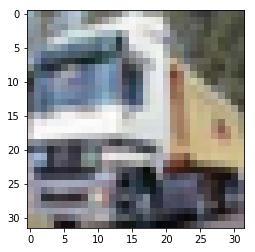

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(train_dataset.train_data[1])

In [47]:
train_dataset.train_labels[0]

6

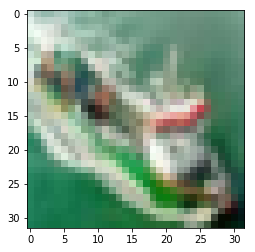

In [48]:
plt.imshow(test_dataset.test_data[15])

In [49]:
test_dataset.test_labels[0]

3

#### Now let's configure the test and train loaders

Here a larger batch size would probably be more approapriate. But as we don't have that much computing power,
we will use a batch size of 32

In [25]:
batch_size = 1024
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          **kwargs)

### Task 2

Next we want to train the network by minimizing the `CrossEntropyLoss` for `50` epochs using the `SGD` and `Adam` optimizer using their default parameters and plot the validation accuracy and test accuracy over the course of the training.

#### Number of epochs

Unfortunately, one epoch takes about an hour to compute on google cloud (we couldn't get a machine with GPUs using
the free account).

In [21]:
epochs = 3

#### Adjust code above

We need to redefine the train and test methods to use another loss function.
Also, we will redefine the optimizer variable to use SGD and Adam for the following task

In [26]:
# adjust test to work with defined loader, we want to be able to plot
# train and validation accuracy

def test(loader):
    model.eval()
    
    test_loss = 0
    correct = 0
    for data, target in loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(loader.dataset)

    return 100. * correct / len(loader.dataset), test_loss

In [27]:
def train(epoch, callback):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        
        output = model(data)
        
        loss = F.cross_entropy(output, target)
        loss.backward()
        
        optimizer.step()
        
        callback(batch_idx, output, target)
        
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data[0]))

#### Let's start with SGD first

In [54]:
optimizer = optim.SGD(model.parameters(), lr=0.1)
sgd_batch_accuracy = []

#### Plotting

The exercise demands, that we plot the test and validation accuracy over the course of the iterations. Though that operation (if we udnestand it correctly) would take massive computation time, as it needs to predict all test and train examples and calculate the percentage of the right answers. Therefore, we actually save the accuracy within a batch and will plot that at the end. We hope that the overall test accuracy will be sufficient. Although we used
google cloud, this NN is still huge enough for us to not be able to wait for it to compute.

In [28]:
def save_accuracy(i, output, target, save_in):
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.data.view_as(pred)).cpu().sum()
    save_in.append(100. * correct / len(output))
    
def get_save_acc_in(save_in):
    return lambda x, y, z: save_accuracy(x, y, z, save_in)

##### Batch size timing

* batch size = 256
  * execution time for 1024 examples was 1min 16s
  * batch size = 512
  * execution time for 1024 examples was 1min 20s
* batch size = 1024
  * execution time for 1024 examples was 1min 17s
* batch size = 2048
  * execution time for 1024 examples was 1min 21s (aprox.)
  
So I guess it doesn't really matter, we picked a batch size of 1024

In [53]:
for epoch in range(epochs):
    train(epoch, get_save_acc_in(sgd_batch_accuracy))

Train Epoch: 0 [1024/50000 (2%)]	Loss: 1.977877
Train Epoch: 0 [2048/50000 (4%)]	Loss: 2.105284
Train Epoch: 0 [3072/50000 (6%)]	Loss: 2.783719
Train Epoch: 0 [4096/50000 (8%)]	Loss: 3.045077
Train Epoch: 0 [5120/50000 (10%)]	Loss: 3.122360
Train Epoch: 0 [6144/50000 (12%)]	Loss: 3.072208
Train Epoch: 0 [7168/50000 (14%)]	Loss: 2.654359
Train Epoch: 0 [8192/50000 (16%)]	Loss: 2.530990
Train Epoch: 0 [9216/50000 (18%)]	Loss: 2.415705
Train Epoch: 0 [10240/50000 (20%)]	Loss: 2.299688
Train Epoch: 0 [11264/50000 (22%)]	Loss: 2.024549
Train Epoch: 0 [12288/50000 (24%)]	Loss: 1.925836
Train Epoch: 0 [13312/50000 (27%)]	Loss: 1.872240
Train Epoch: 0 [14336/50000 (29%)]	Loss: 1.815842
Train Epoch: 0 [15360/50000 (31%)]	Loss: 1.890491
Train Epoch: 0 [16384/50000 (33%)]	Loss: 1.895766
Train Epoch: 0 [17408/50000 (35%)]	Loss: 1.920358
Train Epoch: 0 [18432/50000 (37%)]	Loss: 1.955443
Train Epoch: 0 [19456/50000 (39%)]	Loss: 1.867672
Train Epoch: 0 [20480/50000 (41%)]	Loss: 1.833512
Train Epoch: 

In [29]:
import numpy as np

def plot_accuracy(accuracy_arr, title, xlabel='Number of batches seen'):
    ax = plt.gca()
    ax.plot(np.arange(len(accuracy_arr)), accuracy_arr)
    # could be more than the total number of batches because of epochs
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy')
    ax.set_xticks(np.arange(len(accuracy_arr)))
    plt.title(title)
    plt.show()
    np.arange(len(accuracy_arr))

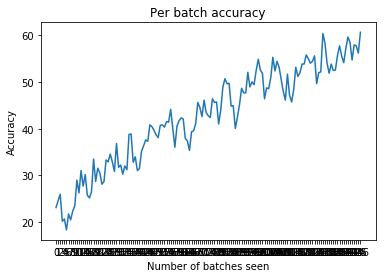

Test score: 48.99


In [55]:
plot_accuracy(sgd_batch_accuracy, 'Per batch accuracy')
print('Test score: {}'.format(test(test_loader)[0]))

#### Analysis

As we can see, the accuracy is oscilating quite a lot. Yes, this is the accuracy per batch, so it is normal
for it to oscilate, but it's not changing much after 1/3 or 2/3 (3 epochs) of the total batches have been seen. Therefore, a smaller (or adaptive) learning rate would be better. As we will see, a smaller learning rate with adam is doing much much better.

#### Adam optimizer

In [25]:
# reset model
model = VGG11()
if torch.cuda.is_available():
    model.cuda()

In [57]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
adam_batch_accuracy = []

In [58]:
for epoch in range(epochs):
    train(epoch, get_save_acc_in(adam_batch_accuracy))

Train Epoch: 0 [1024/50000 (2%)]	Loss: 2.380256
Train Epoch: 0 [2048/50000 (4%)]	Loss: 2.170019
Train Epoch: 0 [3072/50000 (6%)]	Loss: 2.176694
Train Epoch: 0 [4096/50000 (8%)]	Loss: 2.103282
Train Epoch: 0 [5120/50000 (10%)]	Loss: 1.984854
Train Epoch: 0 [6144/50000 (12%)]	Loss: 1.955996
Train Epoch: 0 [7168/50000 (14%)]	Loss: 1.838020
Train Epoch: 0 [8192/50000 (16%)]	Loss: 1.819293
Train Epoch: 0 [9216/50000 (18%)]	Loss: 1.828984
Train Epoch: 0 [10240/50000 (20%)]	Loss: 1.812622
Train Epoch: 0 [11264/50000 (22%)]	Loss: 1.690862
Train Epoch: 0 [12288/50000 (24%)]	Loss: 1.668069
Train Epoch: 0 [13312/50000 (27%)]	Loss: 1.652639
Train Epoch: 0 [14336/50000 (29%)]	Loss: 1.614523
Train Epoch: 0 [15360/50000 (31%)]	Loss: 1.587058
Train Epoch: 0 [16384/50000 (33%)]	Loss: 1.577112
Train Epoch: 0 [17408/50000 (35%)]	Loss: 1.561184
Train Epoch: 0 [18432/50000 (37%)]	Loss: 1.545814
Train Epoch: 0 [19456/50000 (39%)]	Loss: 1.512490
Train Epoch: 0 [20480/50000 (41%)]	Loss: 1.494896
Train Epoch: 

#### Plot for adam optimizer

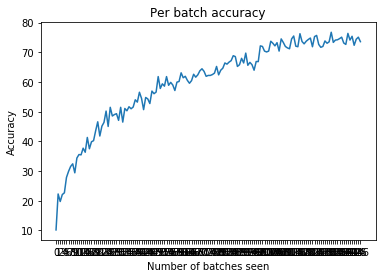

Test score: 69.56


In [60]:
plot_accuracy(adam_batch_accuracy, 'Per batch accuracy')
print('Test score: {}'.format(test(test_loader)[0]))

#### Analysis

As we can see, already on epoch 0 we get better loss value than for SGD. That doesn't really mean Adam is better than SGD, maybe the default learning rate is just better suiting this data set in particular. It starts to oscilate more in the 3. epoch than in the first two, partly because we are closer to the minimum, partly because this learning rate is a little too high as well. We will set it even higher for the next task though, as we are going to be using adaptive learning rate. Our task is to quickly see how the bigger and smaller learning rate of adam work for this dataset, so we can pick a better one for task 4, as we have time for only one full training before the submission and it probably will be with the adam optimizer.

### Task 3

Now implement decaying the learning rate using the `ReduceLROnPlateau` scheme in your training with $\delta=0.9$ and plot the validation and test accuracy over the course of the training using the `SGD` and `Adam` optimizer. You will need to lookup the PyTorch API to figure out how to use this scheme.

In [30]:
# we hope we have to set the factor to 0.9, as there is no parameter delta
# factor 0.9 makes most sense of them all
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9)

def test_optimizer():
    batch_accuracy = []
    epoch_accuracy = []

    for epoch in range(epochs):
        train(epoch, get_save_acc_in(batch_accuracy))
        accuracy, val_loss = test(test_loader)
        epoch_accuracy.append(accuracy)
        scheduler.step(val_loss)
    
    plot_accuracy(batch_accuracy, 'Per batch accuracy')
    plot_accuracy(epoch_accuracy, 'Test accuracy', 'Epochs')
    print('Test score: {}'.format(epoch_accuracy[-1]))

#### Adam

We try with a little higher learning rate as well, as it will be reduced over the epochs

In [27]:
# reset model
model = VGG11()
if torch.cuda.is_available():
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=0.01)

Train Epoch: 0 [1024/50000 (2%)]	Loss: 2.399801
Train Epoch: 0 [2048/50000 (4%)]	Loss: 4.000216
Train Epoch: 0 [3072/50000 (6%)]	Loss: 2.679014
Train Epoch: 0 [4096/50000 (8%)]	Loss: 2.882195
Train Epoch: 0 [5120/50000 (10%)]	Loss: 2.803565
Train Epoch: 0 [6144/50000 (12%)]	Loss: 2.800226
Train Epoch: 0 [7168/50000 (14%)]	Loss: 2.621348
Train Epoch: 0 [8192/50000 (16%)]	Loss: 2.545079
Train Epoch: 0 [9216/50000 (18%)]	Loss: 2.465338
Train Epoch: 0 [10240/50000 (20%)]	Loss: 2.387605
Train Epoch: 0 [11264/50000 (22%)]	Loss: 2.325139
Train Epoch: 0 [12288/50000 (24%)]	Loss: 2.299726
Train Epoch: 0 [13312/50000 (27%)]	Loss: 2.318286
Train Epoch: 0 [14336/50000 (29%)]	Loss: 2.356219
Train Epoch: 0 [19456/50000 (39%)]	Loss: 2.298836
Train Epoch: 0 [20480/50000 (41%)]	Loss: 2.292555
Train Epoch: 0 [21504/50000 (43%)]	Loss: 2.335790
Train Epoch: 0 [22528/50000 (45%)]	Loss: 2.315226
Train Epoch: 0 [23552/50000 (47%)]	Loss: 2.271573
Train Epoch: 0 [24576/50000 (49%)]	Loss: 2.314317
Train Epoch: 

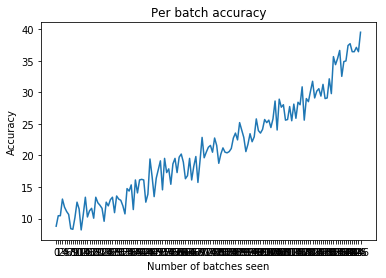

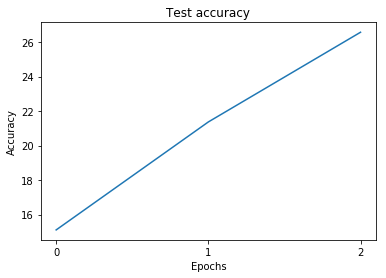

Test score: 26.57


In [ ]:
test_optimizer()

Unfortunately, I lost internet connection, therefore lost connection to the jupyter notebook server at some point and some losses are missing from the log, they are saved in the variable though so plot should be fine.

#### Analysis

So obviously, this learning rate was waaay to big. We hoped that after the first few epochs, as the learning rate is reduced, it will not oscilate as much but will be moving fast enogh as well. After this experiment, it might be wiser to use the default learning rate for the long run, as more learning rate reduction doesn't seem like a better idea. Actually the initial oscilation that we wanted to achieve for faster initial convergation was already well enough (now that we look back) on the previous go. Therefore, for the long run in task 4, we would actually pick a little smaller learning rate (but not factor 10 this time). We think something like 0.0005 should be fine.

#### SGD

As we saw above, the learning rate was already too big for SGD, therefore we are going to decrease it a bit, even though we are going to use an adaptive algorithm. Our goal is to find something that oscilates a bit in the beginning, but not too much, as the learning rate will get smaller over the iterations. If it doesn't oscilate at all at first, we will be converging way to slow after the first few epochs.

Train Epoch: 0 [1024/50000 (2%)]	Loss: 2.390496
Train Epoch: 0 [2048/50000 (4%)]	Loss: 2.233790
Train Epoch: 0 [3072/50000 (6%)]	Loss: 2.170591
Train Epoch: 0 [4096/50000 (8%)]	Loss: 2.089431
Train Epoch: 0 [5120/50000 (10%)]	Loss: 2.046010
Train Epoch: 0 [6144/50000 (12%)]	Loss: 2.032909
Train Epoch: 0 [7168/50000 (14%)]	Loss: 1.916078
Train Epoch: 0 [8192/50000 (16%)]	Loss: 1.935378
Train Epoch: 0 [9216/50000 (18%)]	Loss: 1.882807
Train Epoch: 0 [10240/50000 (20%)]	Loss: 1.856669
Train Epoch: 0 [11264/50000 (22%)]	Loss: 1.819746
Train Epoch: 0 [12288/50000 (24%)]	Loss: 1.806010
Train Epoch: 0 [13312/50000 (27%)]	Loss: 1.791260
Train Epoch: 0 [14336/50000 (29%)]	Loss: 1.718569
Train Epoch: 0 [15360/50000 (31%)]	Loss: 1.709978
Train Epoch: 0 [16384/50000 (33%)]	Loss: 1.707116
Train Epoch: 0 [17408/50000 (35%)]	Loss: 1.706917
Train Epoch: 0 [18432/50000 (37%)]	Loss: 1.671003
Train Epoch: 0 [19456/50000 (39%)]	Loss: 1.676194
Train Epoch: 0 [20480/50000 (41%)]	Loss: 1.648235
Train Epoch: 

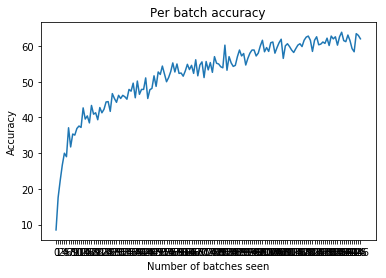

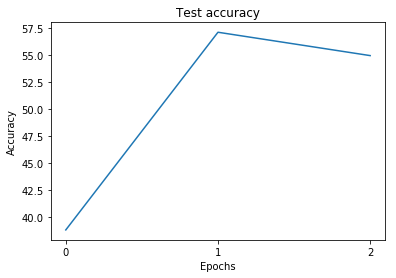

Test score: 54.93


In [27]:
# reset model
model = VGG11()
if torch.cuda.is_available():
    model.cuda()


optimizer = optim.SGD(model.parameters(), lr=0.01)
test_optimizer()

### Task 4

Finally we want to tune the initial step size or  learning rate for the `SGD` and `Adam` for the setup we have till now. 

One strategy is to distribute different learning rates between your fellow classmates and then communicate the best result and refine the learning rate this way till you collectively find the best parameter. This will require some coordination and communication which is what I actually want you do to. Some of your classmates will be confused or stuck, help them! Perhaps you will see some neat helper or good code abstraction, learn from it and apply it to your own code.

Finally, plot the validation accuracy and test accuracy over the course of training for the best learning rate you found for both `SGD` and `Adam`.

#### SGD Optimizer

We decrease the learning rate and increase the learning rate reduction per epoch because of the results above.

Train Epoch: 0 [1024/50000 (2%)]	Loss: 2.387246
Train Epoch: 0 [2048/50000 (4%)]	Loss: 2.283911
Train Epoch: 0 [3072/50000 (6%)]	Loss: 2.198848
Train Epoch: 0 [4096/50000 (8%)]	Loss: 2.161337
Train Epoch: 0 [5120/50000 (10%)]	Loss: 2.104518
Train Epoch: 0 [6144/50000 (12%)]	Loss: 2.059324
Train Epoch: 0 [7168/50000 (14%)]	Loss: 2.057283
Train Epoch: 0 [8192/50000 (16%)]	Loss: 1.990858
Train Epoch: 0 [9216/50000 (18%)]	Loss: 1.972906
Train Epoch: 0 [10240/50000 (20%)]	Loss: 1.932687
Train Epoch: 0 [11264/50000 (22%)]	Loss: 1.904124
Train Epoch: 0 [12288/50000 (24%)]	Loss: 1.879952
Train Epoch: 0 [13312/50000 (27%)]	Loss: 1.871763
Train Epoch: 0 [14336/50000 (29%)]	Loss: 1.817191
Train Epoch: 0 [15360/50000 (31%)]	Loss: 1.824695
Train Epoch: 0 [16384/50000 (33%)]	Loss: 1.788588
Train Epoch: 0 [17408/50000 (35%)]	Loss: 1.790988
Train Epoch: 0 [18432/50000 (37%)]	Loss: 1.768564
Train Epoch: 0 [19456/50000 (39%)]	Loss: 1.762162
Train Epoch: 0 [20480/50000 (41%)]	Loss: 1.752895
Train Epoch: 

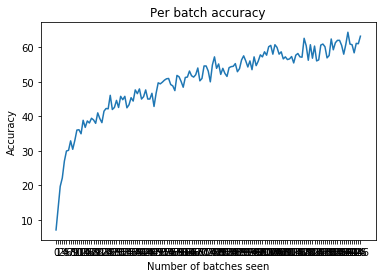

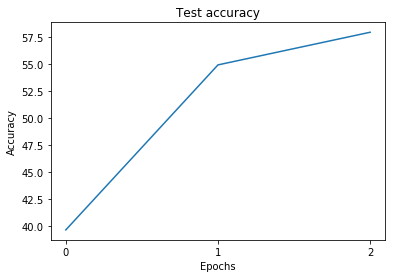

Test score: 57.93


In [28]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.8)

# reset model
model = VGG11()
if torch.cuda.is_available():
    model.cuda()


optimizer = optim.SGD(model.parameters(), lr=0.008)
test_optimizer()

#### Adam Optimizer

In [ ]:
epochs = 50
batch_accuracy = []
epoch_accuracy = []
val_losses = []
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.7)

# reset model
model = VGG11()
if torch.cuda.is_available():
    model.cuda()


optimizer = optim.Adam(model.parameters(), lr=0.0005)


for epoch in range(epochs):
    train(epoch, get_save_acc_in(batch_accuracy))
    accuracy, val_loss = test(test_loader)
    epoch_accuracy.append(accuracy)
    val_losses.append(val_loss)
    scheduler.step(val_loss)


Train Epoch: 0 [1024/50000 (2%)]	Loss: 2.374838
Train Epoch: 0 [2048/50000 (4%)]	Loss: 2.004690
Train Epoch: 0 [3072/50000 (6%)]	Loss: 1.843516
Train Epoch: 0 [4096/50000 (8%)]	Loss: 1.859810
Train Epoch: 0 [5120/50000 (10%)]	Loss: 1.710589
Train Epoch: 0 [6144/50000 (12%)]	Loss: 1.682127
Train Epoch: 0 [7168/50000 (14%)]	Loss: 1.586679
Train Epoch: 0 [8192/50000 (16%)]	Loss: 1.565683
Train Epoch: 0 [9216/50000 (18%)]	Loss: 1.528754
Train Epoch: 0 [10240/50000 (20%)]	Loss: 1.492941
Train Epoch: 0 [11264/50000 (22%)]	Loss: 1.473185
Train Epoch: 0 [12288/50000 (24%)]	Loss: 1.467054
Train Epoch: 0 [13312/50000 (27%)]	Loss: 1.450900
Train Epoch: 0 [14336/50000 (29%)]	Loss: 1.425524
Train Epoch: 0 [15360/50000 (31%)]	Loss: 1.364690
Train Epoch: 0 [16384/50000 (33%)]	Loss: 1.375337
Train Epoch: 0 [17408/50000 (35%)]	Loss: 1.312803
Train Epoch: 0 [18432/50000 (37%)]	Loss: 1.313198
Train Epoch: 0 [19456/50000 (39%)]	Loss: 1.303920
Train Epoch: 0 [20480/50000 (41%)]	Loss: 1.238330
Train Epoch: 

Train Epoch: 3 [19456/50000 (39%)]	Loss: 0.439075
Train Epoch: 3 [20480/50000 (41%)]	Loss: 0.441855
Train Epoch: 3 [21504/50000 (43%)]	Loss: 0.422866
Train Epoch: 3 [22528/50000 (45%)]	Loss: 0.412328
Train Epoch: 3 [23552/50000 (47%)]	Loss: 0.435910
Train Epoch: 3 [24576/50000 (49%)]	Loss: 0.418327
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.445459
Train Epoch: 3 [26624/50000 (53%)]	Loss: 0.472171
Train Epoch: 3 [27648/50000 (55%)]	Loss: 0.425527
Train Epoch: 3 [28672/50000 (57%)]	Loss: 0.454518
Train Epoch: 3 [29696/50000 (59%)]	Loss: 0.460379
Train Epoch: 3 [30720/50000 (61%)]	Loss: 0.451051
Train Epoch: 3 [31744/50000 (63%)]	Loss: 0.486905
Train Epoch: 3 [32768/50000 (65%)]	Loss: 0.498450
Train Epoch: 3 [33792/50000 (67%)]	Loss: 0.487857
Train Epoch: 3 [34816/50000 (69%)]	Loss: 0.493549
Train Epoch: 3 [35840/50000 (71%)]	Loss: 0.443830
Train Epoch: 3 [36864/50000 (73%)]	Loss: 0.434146
Train Epoch: 3 [37888/50000 (76%)]	Loss: 0.449351
Train Epoch: 3 [38912/50000 (78%)]	Loss: 0.435255


Train Epoch: 6 [38912/50000 (78%)]	Loss: 0.154286
Train Epoch: 6 [39936/50000 (80%)]	Loss: 0.149412
Train Epoch: 6 [40960/50000 (82%)]	Loss: 0.121796
Train Epoch: 6 [41984/50000 (84%)]	Loss: 0.140224
Train Epoch: 6 [43008/50000 (86%)]	Loss: 0.174081
Train Epoch: 6 [44032/50000 (88%)]	Loss: 0.125083
Train Epoch: 6 [45056/50000 (90%)]	Loss: 0.169089
Train Epoch: 6 [46080/50000 (92%)]	Loss: 0.139112
Train Epoch: 6 [47104/50000 (94%)]	Loss: 0.135659
Train Epoch: 6 [48128/50000 (96%)]	Loss: 0.175264
Train Epoch: 6 [49152/50000 (98%)]	Loss: 0.166490
Train Epoch: 6 [41552/50000 (100%)]	Loss: 0.151114
Train Epoch: 7 [1024/50000 (2%)]	Loss: 0.095550
Train Epoch: 7 [2048/50000 (4%)]	Loss: 0.103377
Train Epoch: 7 [3072/50000 (6%)]	Loss: 0.093483
Train Epoch: 7 [4096/50000 (8%)]	Loss: 0.093112
Train Epoch: 7 [5120/50000 (10%)]	Loss: 0.072140
Train Epoch: 7 [6144/50000 (12%)]	Loss: 0.087478
Train Epoch: 7 [7168/50000 (14%)]	Loss: 0.075868
Train Epoch: 7 [8192/50000 (16%)]	Loss: 0.059028
Train Epoch

Train Epoch: 10 [7168/50000 (14%)]	Loss: 0.037644
Train Epoch: 10 [8192/50000 (16%)]	Loss: 0.045245
Train Epoch: 10 [9216/50000 (18%)]	Loss: 0.034227
Train Epoch: 10 [10240/50000 (20%)]	Loss: 0.030860
Train Epoch: 10 [11264/50000 (22%)]	Loss: 0.030024
Train Epoch: 10 [12288/50000 (24%)]	Loss: 0.024586
Train Epoch: 10 [13312/50000 (27%)]	Loss: 0.040423
Train Epoch: 10 [14336/50000 (29%)]	Loss: 0.023384
Train Epoch: 10 [15360/50000 (31%)]	Loss: 0.040054
Train Epoch: 10 [16384/50000 (33%)]	Loss: 0.041825
Train Epoch: 10 [17408/50000 (35%)]	Loss: 0.037319
Train Epoch: 10 [18432/50000 (37%)]	Loss: 0.041944
Train Epoch: 10 [19456/50000 (39%)]	Loss: 0.043798
Train Epoch: 10 [20480/50000 (41%)]	Loss: 0.043150
Train Epoch: 10 [21504/50000 (43%)]	Loss: 0.038139
Train Epoch: 10 [22528/50000 (45%)]	Loss: 0.023905
Train Epoch: 10 [23552/50000 (47%)]	Loss: 0.037171
Train Epoch: 10 [24576/50000 (49%)]	Loss: 0.030635
Train Epoch: 10 [25600/50000 (51%)]	Loss: 0.057429
Train Epoch: 10 [26624/50000 (53%)

Train Epoch: 16 [36864/50000 (73%)]	Loss: 0.034651
Train Epoch: 16 [37888/50000 (76%)]	Loss: 0.050596
Train Epoch: 16 [38912/50000 (78%)]	Loss: 0.029748
Train Epoch: 16 [39936/50000 (80%)]	Loss: 0.027836
Train Epoch: 16 [40960/50000 (82%)]	Loss: 0.057118
Train Epoch: 16 [41984/50000 (84%)]	Loss: 0.020522
Train Epoch: 16 [43008/50000 (86%)]	Loss: 0.038043
Train Epoch: 16 [44032/50000 (88%)]	Loss: 0.028859
Train Epoch: 16 [45056/50000 (90%)]	Loss: 0.040270
Train Epoch: 16 [46080/50000 (92%)]	Loss: 0.025621
Train Epoch: 16 [47104/50000 (94%)]	Loss: 0.032330
Train Epoch: 16 [48128/50000 (96%)]	Loss: 0.042585
Train Epoch: 16 [49152/50000 (98%)]	Loss: 0.033153
Train Epoch: 16 [41552/50000 (100%)]	Loss: 0.030405
Train Epoch: 17 [1024/50000 (2%)]	Loss: 0.031141
Train Epoch: 17 [2048/50000 (4%)]	Loss: 0.020059
Train Epoch: 17 [3072/50000 (6%)]	Loss: 0.022790
Train Epoch: 17 [4096/50000 (8%)]	Loss: 0.024090
Train Epoch: 17 [5120/50000 (10%)]	Loss: 0.024546
Train Epoch: 17 [6144/50000 (12%)]	Loss

Train Epoch: 23 [4096/50000 (8%)]	Loss: 0.014209
Train Epoch: 23 [5120/50000 (10%)]	Loss: 0.018551
Train Epoch: 23 [6144/50000 (12%)]	Loss: 0.007941
Train Epoch: 23 [7168/50000 (14%)]	Loss: 0.015433
Train Epoch: 23 [8192/50000 (16%)]	Loss: 0.027949
Train Epoch: 23 [9216/50000 (18%)]	Loss: 0.012398
Train Epoch: 23 [10240/50000 (20%)]	Loss: 0.013151
Train Epoch: 23 [11264/50000 (22%)]	Loss: 0.012796
Train Epoch: 23 [12288/50000 (24%)]	Loss: 0.021468
Train Epoch: 23 [13312/50000 (27%)]	Loss: 0.015742
Train Epoch: 23 [14336/50000 (29%)]	Loss: 0.029849
Train Epoch: 23 [15360/50000 (31%)]	Loss: 0.007059
Train Epoch: 23 [16384/50000 (33%)]	Loss: 0.018342
Train Epoch: 23 [17408/50000 (35%)]	Loss: 0.020160
Train Epoch: 23 [18432/50000 (37%)]	Loss: 0.014225
Train Epoch: 23 [19456/50000 (39%)]	Loss: 0.020766
Train Epoch: 23 [20480/50000 (41%)]	Loss: 0.016159
Train Epoch: 23 [21504/50000 (43%)]	Loss: 0.012565
Train Epoch: 23 [22528/50000 (45%)]	Loss: 0.014768
Train Epoch: 23 [23552/50000 (47%)]	Lo

Train Epoch: 26 [19456/50000 (39%)]	Loss: 0.015064
Train Epoch: 26 [20480/50000 (41%)]	Loss: 0.023357
Train Epoch: 26 [21504/50000 (43%)]	Loss: 0.021612
Train Epoch: 26 [22528/50000 (45%)]	Loss: 0.013981
Train Epoch: 26 [23552/50000 (47%)]	Loss: 0.027800
Train Epoch: 26 [24576/50000 (49%)]	Loss: 0.021767
Train Epoch: 26 [25600/50000 (51%)]	Loss: 0.012273
Train Epoch: 26 [33792/50000 (67%)]	Loss: 0.020220
Train Epoch: 26 [34816/50000 (69%)]	Loss: 0.014130
Train Epoch: 26 [35840/50000 (71%)]	Loss: 0.020408
Train Epoch: 26 [36864/50000 (73%)]	Loss: 0.017128
Train Epoch: 26 [37888/50000 (76%)]	Loss: 0.013432
Train Epoch: 26 [38912/50000 (78%)]	Loss: 0.022906
Train Epoch: 26 [39936/50000 (80%)]	Loss: 0.028395
Train Epoch: 26 [40960/50000 (82%)]	Loss: 0.019658
Train Epoch: 26 [41984/50000 (84%)]	Loss: 0.015040
Train Epoch: 26 [43008/50000 (86%)]	Loss: 0.014340
Train Epoch: 26 [44032/50000 (88%)]	Loss: 0.023759
Train Epoch: 26 [45056/50000 (90%)]	Loss: 0.014096
Train Epoch: 26 [46080/50000 (9

Train Epoch: 38 [1024/50000 (2%)]	Loss: 0.003508
Train Epoch: 38 [2048/50000 (4%)]	Loss: 0.007302
Train Epoch: 38 [3072/50000 (6%)]	Loss: 0.008264
Train Epoch: 38 [4096/50000 (8%)]	Loss: 0.004182
Train Epoch: 38 [5120/50000 (10%)]	Loss: 0.009962
Train Epoch: 38 [6144/50000 (12%)]	Loss: 0.005455
Train Epoch: 38 [7168/50000 (14%)]	Loss: 0.002833
Train Epoch: 38 [8192/50000 (16%)]	Loss: 0.004106
Train Epoch: 38 [9216/50000 (18%)]	Loss: 0.006887
Train Epoch: 38 [10240/50000 (20%)]	Loss: 0.012358
Train Epoch: 38 [11264/50000 (22%)]	Loss: 0.008296
Train Epoch: 38 [12288/50000 (24%)]	Loss: 0.005132
Train Epoch: 38 [13312/50000 (27%)]	Loss: 0.005869
Train Epoch: 38 [14336/50000 (29%)]	Loss: 0.005995
Train Epoch: 38 [15360/50000 (31%)]	Loss: 0.005110
Train Epoch: 38 [16384/50000 (33%)]	Loss: 0.007575
Train Epoch: 38 [17408/50000 (35%)]	Loss: 0.009468
Train Epoch: 38 [18432/50000 (37%)]	Loss: 0.006575
Train Epoch: 38 [19456/50000 (39%)]	Loss: 0.001398
Train Epoch: 38 [20480/50000 (41%)]	Loss: 0.

Train Epoch: 41 [16384/50000 (33%)]	Loss: 0.002414
Train Epoch: 41 [17408/50000 (35%)]	Loss: 0.003308
Train Epoch: 41 [18432/50000 (37%)]	Loss: 0.001423
Train Epoch: 41 [19456/50000 (39%)]	Loss: 0.003618
Train Epoch: 41 [20480/50000 (41%)]	Loss: 0.005141
Train Epoch: 41 [21504/50000 (43%)]	Loss: 0.003649
Train Epoch: 41 [22528/50000 (45%)]	Loss: 0.003594
Train Epoch: 41 [23552/50000 (47%)]	Loss: 0.004601
Train Epoch: 41 [24576/50000 (49%)]	Loss: 0.002715
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.002285
Train Epoch: 41 [26624/50000 (53%)]	Loss: 0.005929
Train Epoch: 41 [27648/50000 (55%)]	Loss: 0.002545
Train Epoch: 41 [28672/50000 (57%)]	Loss: 0.009609
Train Epoch: 41 [29696/50000 (59%)]	Loss: 0.002913
Train Epoch: 41 [30720/50000 (61%)]	Loss: 0.001424
Train Epoch: 41 [31744/50000 (63%)]	Loss: 0.002324
Train Epoch: 41 [32768/50000 (65%)]	Loss: 0.003818
Train Epoch: 41 [33792/50000 (67%)]	Loss: 0.001889
Train Epoch: 41 [34816/50000 (69%)]	Loss: 0.002141
Train Epoch: 41 [35840/50000 (7

Train Epoch: 44 [31744/50000 (63%)]	Loss: 0.003309
Train Epoch: 44 [32768/50000 (65%)]	Loss: 0.003537
Train Epoch: 44 [33792/50000 (67%)]	Loss: 0.001769
Train Epoch: 44 [34816/50000 (69%)]	Loss: 0.001471
Train Epoch: 44 [35840/50000 (71%)]	Loss: 0.004570
Train Epoch: 44 [36864/50000 (73%)]	Loss: 0.001914
Train Epoch: 44 [37888/50000 (76%)]	Loss: 0.005946
Train Epoch: 44 [38912/50000 (78%)]	Loss: 0.002521
Train Epoch: 44 [39936/50000 (80%)]	Loss: 0.001487
Train Epoch: 44 [40960/50000 (82%)]	Loss: 0.002386
Train Epoch: 44 [41984/50000 (84%)]	Loss: 0.001837
Train Epoch: 44 [43008/50000 (86%)]	Loss: 0.002007
Train Epoch: 44 [44032/50000 (88%)]	Loss: 0.005284
Train Epoch: 44 [45056/50000 (90%)]	Loss: 0.004127
Train Epoch: 44 [46080/50000 (92%)]	Loss: 0.002059
Train Epoch: 44 [47104/50000 (94%)]	Loss: 0.006195
Train Epoch: 44 [48128/50000 (96%)]	Loss: 0.005256
Train Epoch: 44 [49152/50000 (98%)]	Loss: 0.002076
Train Epoch: 44 [41552/50000 (100%)]	Loss: 0.004364
Train Epoch: 45 [1024/50000 (2

Train Epoch: 47 [47104/50000 (94%)]	Loss: 0.055446
Train Epoch: 47 [48128/50000 (96%)]	Loss: 0.051065
Train Epoch: 47 [49152/50000 (98%)]	Loss: 0.031105
Train Epoch: 47 [41552/50000 (100%)]	Loss: 0.019653
Train Epoch: 48 [1024/50000 (2%)]	Loss: 0.013143
Train Epoch: 48 [2048/50000 (4%)]	Loss: 0.020709
Train Epoch: 48 [3072/50000 (6%)]	Loss: 0.031039
Train Epoch: 48 [4096/50000 (8%)]	Loss: 0.024046
Train Epoch: 48 [5120/50000 (10%)]	Loss: 0.030541
Train Epoch: 48 [6144/50000 (12%)]	Loss: 0.049124
Train Epoch: 48 [7168/50000 (14%)]	Loss: 0.043341
Train Epoch: 48 [8192/50000 (16%)]	Loss: 0.024614
Train Epoch: 48 [9216/50000 (18%)]	Loss: 0.037618
Train Epoch: 48 [10240/50000 (20%)]	Loss: 0.030710
Train Epoch: 48 [11264/50000 (22%)]	Loss: 0.040722
Train Epoch: 48 [12288/50000 (24%)]	Loss: 0.036990
Train Epoch: 48 [13312/50000 (27%)]	Loss: 0.031692
Train Epoch: 48 [14336/50000 (29%)]	Loss: 0.037312
Train Epoch: 48 [15360/50000 (31%)]	Loss: 0.052268
Train Epoch: 48 [16384/50000 (33%)]	Loss: 0

#### And at this moment, I got home and jupyter notebook has crashed on the google server...

No error message whatsoever

#### Analysis

As we can see from the losses though, this learning rate was waaay to big or the factor for the adaptive
learning rate adjustment. We had to decrease the learning rate further to achieve better results.

This training took 40h approximately, so we can only afford to do a low amount of epochs again. Best accuracy is reached on 7th epoch (approximately) with the used learning rate. As we cannot train the model longer, we will get 5 epochs with the same parameters to try to plot the accuracy or at least see how goo approximately we got.

In [ ]:
epochs = 5
batch_accuracy = []
epoch_accuracy = []
val_losses = []
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.7)

# reset model
model = VGG11()
if torch.cuda.is_available():
    model.cuda()


optimizer = optim.Adam(model.parameters(), lr=0.0005)


for epoch in range(epochs):
    train(epoch, get_save_acc_in(batch_accuracy))
    accuracy, val_loss = test(test_loader)
    epoch_accuracy.append(accuracy)
    val_losses.append(val_loss)
    scheduler.step(val_loss)


Train Epoch: 0 [1024/50000 (2%)]	Loss: 2.430263
Train Epoch: 0 [2048/50000 (4%)]	Loss: 2.081038
Train Epoch: 0 [3072/50000 (6%)]	Loss: 1.944458
Train Epoch: 0 [4096/50000 (8%)]	Loss: 1.842913
Train Epoch: 0 [5120/50000 (10%)]	Loss: 1.744292
Train Epoch: 0 [6144/50000 (12%)]	Loss: 1.733281
Train Epoch: 0 [7168/50000 (14%)]	Loss: 1.630509
Train Epoch: 0 [8192/50000 (16%)]	Loss: 1.571738
Train Epoch: 0 [9216/50000 (18%)]	Loss: 1.550751
Train Epoch: 0 [10240/50000 (20%)]	Loss: 1.560912
Train Epoch: 0 [11264/50000 (22%)]	Loss: 1.507527
Train Epoch: 0 [12288/50000 (24%)]	Loss: 1.427238
Train Epoch: 0 [13312/50000 (27%)]	Loss: 1.436990
Train Epoch: 0 [14336/50000 (29%)]	Loss: 1.404583
Train Epoch: 0 [15360/50000 (31%)]	Loss: 1.380237
Train Epoch: 0 [16384/50000 (33%)]	Loss: 1.302534


#### Result

it is actually finished, just the notebook wasn't open at the time but the server did it's job this time

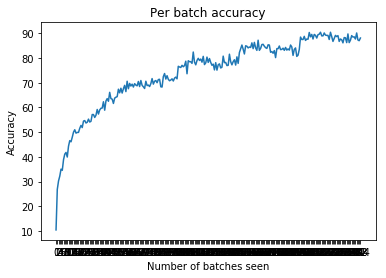

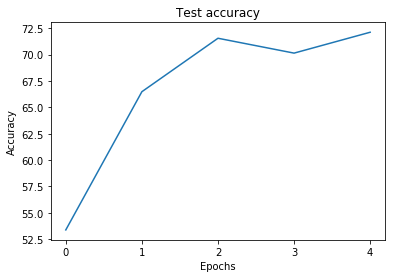

Test score: 72.12


In [34]:
plot_accuracy(batch_accuracy, 'Per batch accuracy')
plot_accuracy(epoch_accuracy, 'Test accuracy', 'Epochs')
print('Test score: {}'.format(epoch_accuracy[-1]))

### Final analysis

As we see, the learning rate adjustment factor was way too bit, therefore the was quite a lot of oscilation. Unfortunately, we can't really tell much more about that, as this is the per batch accuracy and not the total one. The total (test set) accuracy was measured only after each batch and it drops quite a bit after the 4. (index 3) epoch, so we could have done better with a smaller learning rate and a bigger factor for the adaptive algorithm (default factor was 0.1 after all, maybe we didn't understand the exercise right, factor of 0.9 or 0.7 is adjusting the learning rate quite minimally, not enogh to be seen in 5 epochs).


Well sorry for the chaotically analysed, chaotically programmed and executed homework, we had some computation issues. We should have either started earlier or just do even more computations with less epochs and again only one bigger, but not as big as 50 epochs.